Loaded ISO 4: raw n=3987, after clean n=3987
GMM AIC: -2637.54
GMM BIC: -926.45

Cluster summary:
 cluster    n  sd_mean   sd_std  conf_mean     x_mean    y_mean
       0 1027 1.243386 0.098629   0.998265 182.371841 39.620144
       1 1862 0.783955 0.491235   0.999197 210.622025 37.602337
       2 1098 1.220232 0.100498   0.997594 185.588120 60.633240


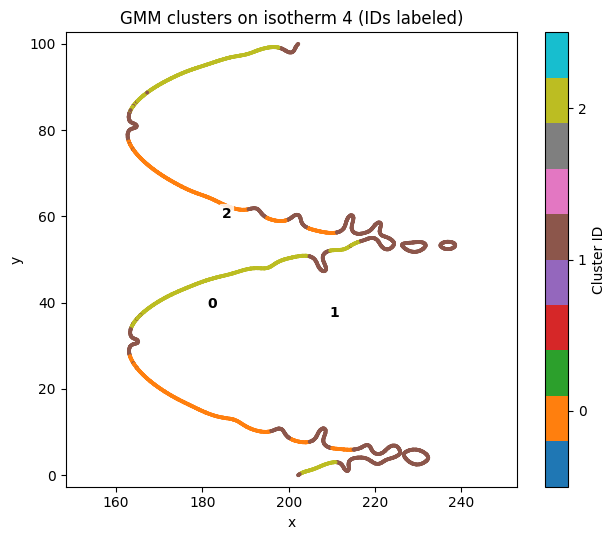


--- Cluster 0 | n=1027 ---
R^2=0.9912 | RMSE=9.130805e-03
Importance method: shap
Top features:
  01. du_ndy  (3.6412e-02)
  02. u_t  (2.6210e-02)
  03. du_ndx  (1.7491e-02)
  04. du_tdx  (9.7809e-03)
  05. normal_strain_rate  (2.2338e-03)
  06. curvature  (2.1983e-03)
  07. u_n  (1.8332e-03)
  08. dcurvdx  (1.3153e-03)
  09. tangential_strain_rate  (1.0655e-03)
  10. du_tdy  (9.5354e-04)
  11. vorticity  (7.5018e-04)
  12. dcurvdy  (4.7726e-04)


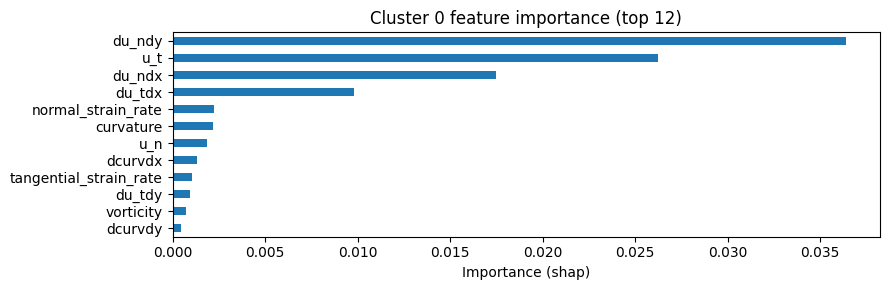


--- Cluster 1 | n=1862 ---
R^2=0.9374 | RMSE=1.241050e-01
Importance method: shap
Top features:
  01. curvature  (2.5989e-01)
  02. du_ndx  (1.2688e-01)
  03. tangential_strain_rate  (4.6966e-02)
  04. vorticity  (4.5931e-02)
  05. dcurvdx  (3.3568e-02)
  06. u_n  (2.8540e-02)
  07. u_t  (2.5978e-02)
  08. du_ndy  (2.1583e-02)
  09. dcurvdy  (1.5737e-02)
  10. du_tdy  (1.4771e-02)
  11. du_tdx  (1.2250e-02)
  12. normal_strain_rate  (6.4888e-03)


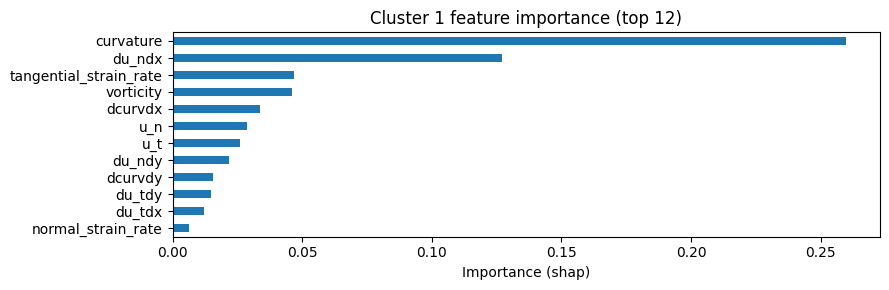


--- Cluster 2 | n=1098 ---
R^2=0.9920 | RMSE=8.857638e-03
Importance method: shap
Top features:
  01. u_t  (4.4152e-02)
  02. du_ndy  (2.6120e-02)
  03. du_tdx  (7.0778e-03)
  04. du_ndx  (4.7380e-03)
  05. du_tdy  (2.1574e-03)
  06. curvature  (2.0892e-03)
  07. u_n  (1.9754e-03)
  08. tangential_strain_rate  (1.5794e-03)
  09. normal_strain_rate  (1.4832e-03)
  10. vorticity  (1.3167e-03)
  11. dcurvdx  (8.7615e-04)
  12. dcurvdy  (2.7706e-04)


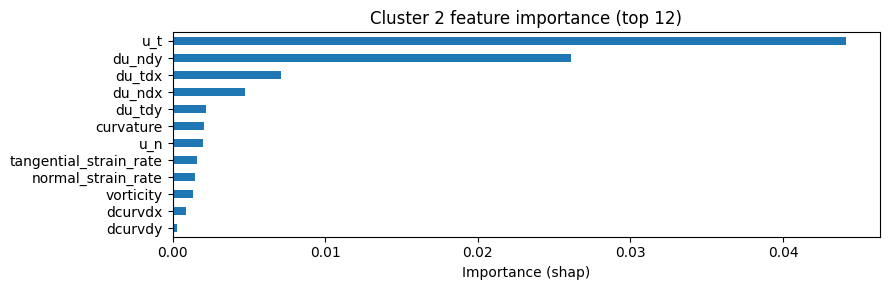


Per-cluster model metrics:
 cluster    n       r2     rmse importance_method
       0 1027 0.991161 0.009131              shap
       1 1862 0.937389 0.124105              shap
       2 1098 0.992007 0.008858              shap


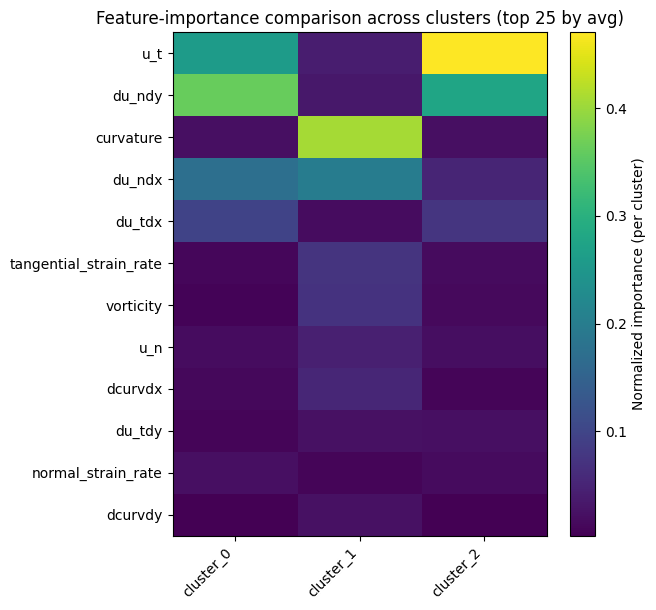


Top features (normalized importance per cluster):
                        cluster_0  cluster_1  cluster_2
u_t                        0.2602     0.0407     0.4705
du_ndy                     0.3615     0.0338     0.2783
curvature                  0.0218     0.4070     0.0223
du_ndx                     0.1737     0.1987     0.0505
du_tdx                     0.0971     0.0192     0.0754
tangential_strain_rate     0.0106     0.0735     0.0168
vorticity                  0.0074     0.0719     0.0140
u_n                        0.0182     0.0447     0.0211
dcurvdx                    0.0131     0.0526     0.0093
du_tdy                     0.0095     0.0231     0.0230
normal_strain_rate         0.0222     0.0102     0.0158
dcurvdy                    0.0047     0.0246     0.0030


In [6]:
from __future__ import annotations
from flamekit.io_fronts import Case, load_fronts
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

## Input Parameters

BASE_DIR = Path("../isocontours")
PHI = 0.40
LAT_SIZE = "100"
TIME_STEP = 210
POST = True

TARGET_VAR = "DW_FDS"
ISOLEVEL = 4

# -------------------------
# MISSING SETTINGS (DEFINED)
# -------------------------
CLUSTER_ON_SPATIAL = False  # if True, x,y,z can be included as clustering features

COLS_TO_INCLUDE = {
    "curvature",
    "dcurvdx",
    "dcurvdy",
    "tangential_strain_rate",
    "normal_strain_rate",
    "vorticity",
    "u_n",
    "u_t",
    "du_ndx",
    "du_ndy",
    "du_tdx",
    "du_tdy",
}

N_CLUSTERS = 3

GMM_PARAMS = dict(
    covariance_type="full",
    reg_covar=1e-6,
    max_iter=300,
    n_init=5,
    random_state=0,
)

MIN_CLUSTER_SAMPLES = 50
TEST_SIZE = 0.25
RANDOM_STATE = 0

MODEL_PARAMS = dict(
    n_estimators=400,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

TOPN_PRINT = 12
TOPN_HEATMAP = 25

CASE = Case(
    base_dir=BASE_DIR,
    phi=PHI,
    lat_size=LAT_SIZE,
    time_step=TIME_STEP,
    post=POST,
)

fronts = load_fronts(CASE, [ISOLEVEL])
df = fronts[ISOLEVEL].copy()
df["c_iso"] = float(ISOLEVEL)


# =========================
# Feature utilities
# =========================

def numeric_feature_list_from_include(df: pd.DataFrame, include: List[str]) -> List[str]:
    return [
        c for c in include
        if (c in df.columns) and pd.api.types.is_numeric_dtype(df[c])
    ]


def labeled_cluster_plot_xy(dfc: pd.DataFrame, n_clusters: int, title: str):
    if "x" not in dfc.columns or "y" not in dfc.columns:
        return

    plt.figure(figsize=(6.5, 5.5))
    sc = plt.scatter(
        dfc["x"], dfc["y"],
        c=dfc["cluster"],
        s=3,
        cmap="tab10",
        vmin=-0.5,
        vmax=n_clusters - 0.5,
    )
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)

    cbar = plt.colorbar(sc, ticks=np.arange(n_clusters))
    cbar.set_label("Cluster ID")
    cbar.ax.set_yticklabels([str(i) for i in range(n_clusters)])

    centroids_xy = dfc.groupby("cluster")[["x", "y"]].mean().reset_index()
    for _, row in centroids_xy.iterrows():
        cl = int(row["cluster"])
        plt.text(
            row["x"], row["y"], str(cl),
            ha="center", va="center",
            fontsize=10, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.85, ec="none"),
        )

    plt.tight_layout()
    plt.show()


# =========================
# Importance (SHAP preferred, fallback to permutation)
# =========================

def compute_importance(
        model,
        X_test: np.ndarray,
        y_test: np.ndarray,
        feature_names: List[str],
        prefer_shap: bool = True,
        random_state: int = 0,
) -> Tuple[pd.Series, str]:
    """
    Returns:
      importance: pd.Series indexed by feature_names
      method: "shap" or "permutation"
    """
    if prefer_shap:
        try:
            import shap  # type: ignore
            explainer = shap.TreeExplainer(model)
            shap_vals = explainer.shap_values(X_test)  # (n_samples, n_features)
            imp = np.mean(np.abs(shap_vals), axis=0)
            s = pd.Series(imp, index=feature_names).sort_values(ascending=False)
            return s, "shap"
        except Exception:
            pass

    pi = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=random_state,
        n_jobs=-1,
        scoring="r2",
    )
    s = pd.Series(pi.importances_mean, index=feature_names).sort_values(ascending=False)
    return s, "permutation"


# ============================================================
# RUN (Notebook cell)
# ============================================================

if TARGET_VAR not in df.columns:
    raise ValueError(f"TARGET_VAR '{TARGET_VAR}' not found in dataframe.")

# Start from your baseline include list
include_for_cluster = list(COLS_TO_INCLUDE)

# If you want to allow x,y,z in clustering when CLUSTER_ON_SPATIAL=True,
# add them explicitly (they were excluded before).
if CLUSTER_ON_SPATIAL:
    for c in ["x", "y", "z"]:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]) and c not in include_for_cluster:
            include_for_cluster.append(c)

cluster_features = numeric_feature_list_from_include(df, include=include_for_cluster)
if len(cluster_features) == 0:
    raise ValueError("No numeric clustering features left after inclusions.")

# Model features (same as clustering features by default)
model_features = cluster_features
feature_names = list(model_features)

# Clean rows (require model_features + target)
dfc = df.dropna(subset=model_features + [TARGET_VAR]).copy()
print(f"Loaded ISO {ISOLEVEL}: raw n={len(df)}, after clean n={len(dfc)}")

# Standardize for GMM
Xc = dfc[cluster_features].to_numpy()
scaler = StandardScaler()
Xc_s = scaler.fit_transform(Xc)

# Fit GMM + assign clusters
gmm = GaussianMixture(n_components=N_CLUSTERS, **GMM_PARAMS)
dfc["cluster"] = gmm.fit_predict(Xc_s)

# Optional: membership confidence (max posterior prob)
probs = gmm.predict_proba(Xc_s)
dfc["cluster_conf"] = probs.max(axis=1)

# Diagnostics: BIC/AIC
print(f"GMM AIC: {gmm.aic(Xc_s):.2f}")
print(f"GMM BIC: {gmm.bic(Xc_s):.2f}")

# Cluster summary
summary = (
    dfc.groupby("cluster")
    .agg(
        n=(TARGET_VAR, "size"),
        sd_mean=(TARGET_VAR, "mean"),
        sd_std=(TARGET_VAR, "std"),
        conf_mean=("cluster_conf", "mean"),
    )
    .reset_index()
    .sort_values("cluster")
)

if "x" in dfc.columns and "y" in dfc.columns:
    xy = (
        dfc.groupby("cluster")[["x", "y"]]
        .mean()
        .reset_index()
        .rename(columns={"x": "x_mean", "y": "y_mean"})
    )
    summary = summary.merge(xy, on="cluster", how="left")

print("\nCluster summary:")
print(summary.to_string(index=False))

labeled_cluster_plot_xy(
    dfc, N_CLUSTERS,
    title=f"GMM clusters on isotherm {ISOLEVEL} (IDs labeled)"
)

# Train separate model per cluster and compute importance
importances: Dict[int, pd.Series] = {}
metrics: List[dict] = []
used_method: Dict[int, str] = {}

for cl in range(N_CLUSTERS):
    sub = dfc[dfc["cluster"] == cl].copy()
    n_cl = len(sub)
    print(f"\n--- Cluster {cl} | n={n_cl} ---")

    if n_cl < MIN_CLUSTER_SAMPLES:
        print(f"Skipping (n < MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
        continue

    X = sub[model_features].to_numpy()
    y = sub[TARGET_VAR].to_numpy()

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    model = RandomForestRegressor(**MODEL_PARAMS)
    model.fit(Xtr, ytr)

    ypred = model.predict(Xte)
    r2 = r2_score(yte, ypred)
    rmse = float(np.sqrt(mean_squared_error(yte, ypred)))
    print(f"R^2={r2:.4f} | RMSE={rmse:.6e}")

    imp, method = compute_importance(
        model=model,
        X_test=Xte,
        y_test=yte,
        feature_names=feature_names,
        prefer_shap=True,
        random_state=RANDOM_STATE,
    )
    used_method[cl] = method
    importances[cl] = imp

    print(f"Importance method: {method}")
    print("Top features:")
    for i, (fname, val) in enumerate(imp.head(TOPN_PRINT).items(), 1):
        print(f"  {i:02d}. {fname}  ({val:.4e})")

    metrics.append({"cluster": cl, "n": n_cl, "r2": float(r2), "rmse": rmse, "importance_method": method})

    top = imp.head(TOPN_PRINT).iloc[::-1]
    plt.figure(figsize=(9, 3))
    top.plot(kind="barh")
    plt.xlabel(f"Importance ({method})")
    plt.title(f"Cluster {cl} feature importance (top {TOPN_PRINT})")
    plt.tight_layout()
    plt.show()

# Metrics table
if metrics:
    metrics_df = pd.DataFrame(metrics).sort_values("cluster")
    print("\nPer-cluster model metrics:")
    print(metrics_df.to_string(index=False))
else:
    print("\nNo clusters satisfied MIN_CLUSTER_SAMPLES; nothing trained.")

# Compare importances across clusters (heatmap)
if importances:
    trained_clusters = sorted(importances.keys())

    # Common feature index
    common_feats = set(feature_names)
    for cl in trained_clusters:
        common_feats = common_feats.intersection(importances[cl].index.tolist())
    common_feats = list(common_feats)

    imp_mat = pd.DataFrame(index=common_feats)
    for cl in trained_clusters:
        imp_mat[f"cluster_{cl}"] = importances[cl].reindex(common_feats).fillna(0.0)

    # Normalize per cluster
    imp_norm = imp_mat.copy()
    for col in imp_norm.columns:
        s = imp_norm[col].sum()
        if s > 0:
            imp_norm[col] /= s

    imp_norm["avg"] = imp_norm.mean(axis=1)
    top_feats = imp_norm.sort_values("avg", ascending=False).head(TOPN_HEATMAP).index
    heat = imp_norm.loc[top_feats, [c for c in imp_norm.columns if c != "avg"]]

    plt.figure(figsize=(1.2 * len(trained_clusters) + 3, 0.35 * len(top_feats) + 2))
    plt.imshow(heat.to_numpy(), aspect="auto")
    plt.xticks(np.arange(len(heat.columns)), heat.columns, rotation=45, ha="right")
    plt.yticks(np.arange(len(heat.index)), heat.index)
    plt.colorbar(label="Normalized importance (per cluster)")
    plt.title(f"Feature-importance comparison across clusters (top {TOPN_HEATMAP} by avg)")
    plt.tight_layout()
    plt.show()

    print("\nTop features (normalized importance per cluster):")
    print(heat.round(4).to_string())
